In [2]:
from typing import Dict, List

import pymatching
import numpy as np

from soft_info import get_repcode_IQ_map, llh_ratio


def soft_reweight_pymatching(matching : pymatching.Matching,  d : int, T : int, IQ_data, 
                             kde_dict: Dict, layout : List[int], scaler_dict : Dict,
                             p_data : float = None, p_meas : float = None, common_measure = None):

    p_data = p_data if p_data is not None else 6.836e-3  # Sherbrooke median
    p_meas = p_meas if p_meas is not None else 0

    if layout is not None:
        qubit_mapping = get_repcode_IQ_map(layout, T)

    for edge in matching.edges():

        if edge[1]==None: # always second pose None
            #Boundary edge (logical on it)
            edge[2]['weight'] = -np.log(p_data/(1-p_data)) # dict always in third pos
            continue

        if edge[1]==edge[0]+1: # always first pos the smaller
            #Data edge
            edge[2]['weight'] = -np.log(p_data/(1-p_data)) # dict always in third pos

            if common_measure is not None:
                edge[2]['weight'] = round( edge[2]['weight']/ common_measure) * common_measure


            ##############################################################################
            continue  # next iteration because dont need to change the rest of the weights
            ##############################################################################

        if edge[1]==edge[0]+d:
            #Time edge
            edge[2]['weight'] = -np.log(p_meas/(1-p_meas))
        
        if edge[1]==edge[0]+d+1:
            #Time and data edge
            edge[2]['weight'] = -np.log(p_data/(1-p_data)) - np.log(p_meas/(1-p_meas))

        src_node, tgt_node = edge[0], edge[1]

        #Structure of IQ data = [link_0, link_1, link_3, link_0, link_1, .., code_qubit_1, ...]
        # equivalent to       = [node_0, node_1, node_3, node_4, node_5, .. ]
        # =>
        IQ_point = IQ_data[src_node]
        link_qubit_index = src_node % d # gives the inex of the link qubit register TODO: remove this?
        layout_qubit_idx = qubit_mapping[link_qubit_index] #TODO check if this is correct. Yes because node_idx gives number in the IQ data as well

        kde_0, kde_1 = kde_dict.get(layout_qubit_idx, (None, None))
        scaler = scaler_dict.get(layout_qubit_idx, None)

        weight = llh_ratio(IQ_point, kde_0, kde_1, scaler)

        edge[2]['weight'] += weight

        #Round the weights to common measure
        if common_measure is not None:
            edge[2]['weight'] = round( edge[2]['weight']/ common_measure) * common_measure








In [6]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_matching_graph(matching, d, T):
    G = nx.Graph()
    pos = {}
    edge_colors = []
    
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is not None:
            G.add_edge(src_node, tgt_node, weight=edge_data['weight'])
            if edge_data.get('fault_ids'):
                edge_colors.append('r')
            else:
                edge_colors.append('k')
        
        x_src = src_node % (d-1)
        y_src = src_node // (d-1)
        pos[src_node] = (x_src, -y_src)
    
    nx.draw(G, pos, with_labels=True, node_color='white', edge_color=edge_colors, font_weight='bold', node_size=700, font_size=18)
    
    edge_weights = nx.get_edge_attributes(G, 'weight')
    labels = {k: f"{v:.2f}" for k, v in edge_weights.items()}
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if tgt_node is None:
            x_src = src_node % (d-1)
            y_src = src_node // (d-1)
            color = 'r' if edge_data.get('fault_ids') == set() else 'k'
            weight_text = f"{edge_data.get('weight'):.2f}"
            if x_src == 0:
                plt.plot([x_src, x_src - 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src - 0.3, -y_src + 0.05, weight_text)
            elif x_src == d - 2:
                plt.plot([x_src, x_src + 0.5], [-y_src, -y_src], color=color)
                plt.text(x_src + 0.2, -y_src + 0.05, weight_text)

    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=700)
    
    plt.show()

In [44]:
from typing import Dict, List

import pymatching
import numpy as np

from soft_info import get_repcode_IQ_map, llh_ratio

def soft_reweight_pymatching(matching : pymatching.Matching,  d : int, T : int, IQ_data, 
                             kde_dict: dict, layout : list, scaler_dict : dict,
                             p_data : float = None, p_meas : float = None, common_measure = None,
                             verbose : bool = False):

    p_data = p_data if p_data is not None else 6.836e-3  # Sherbrooke median
    p_meas = p_meas if p_meas is not None else 0

    if layout is not None:
        qubit_mapping = get_repcode_IQ_map(layout, T)

    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        if verbose:
            print("\nEdge:", (src_node, tgt_node))
        fault_ids = edge_data.get('fault_ids', set())
        error_probability = edge_data.get('error_probability', -1.0)
        
        if tgt_node is None:  # always second pose None
            # Boundary edge (logical on it)
            new_weight = -np.log(p_data / (1 - p_data))

            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure
                
            matching.add_boundary_edge(src_node, weight=new_weight, fault_ids=fault_ids, 
                              error_probability=error_probability, merge_strategy="replace")
            if verbose:
                print("Boundary edge weight: ", new_weight)

            _has_time_component = False
            continue
        elif tgt_node == src_node + 1:  # always first pos the smaller
            # Data edge
            new_weight = -np.log(p_data / (1 - p_data))
            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure
            if verbose:
                print("Data edge weight: ", new_weight)
        elif tgt_node == src_node + (d-1):
            # Time edge
            #TODO implement adding a new edge for hard meas flip
            new_weight = 0 #-np.log(p_meas / (1 - p_meas))
            _has_time_component = True
            if verbose:
                print("Time edge weight: ", new_weight)
        elif tgt_node == src_node + (d-1) + 1:
            # mixed edge
            # TODO implement adding a new DIAG edge for hard meas flip
            new_weight = -np.log(p_data / (1 - p_data))# - np.log(p_meas / (1 - p_meas))
            _has_time_component = True
            if verbose:
                print("Mixed edge weight: ", new_weight)

        if _has_time_component: 
            #Structure of IQ data = [link_0, link_1, link_3, link_0, link_1, .., code_qubit_1, ...]
            # equivalent to       = [node_0, node_1, node_3, node_4, node_5, .. ]
            # =>
            IQ_point = IQ_data[src_node]
            layout_qubit_idx = qubit_mapping[src_node]
            kde_0, kde_1 = kde_dict.get(layout_qubit_idx, (None, None))
            scaler = scaler_dict.get(layout_qubit_idx, None)
            llh_weight = llh_ratio(IQ_point, kde_0, kde_1, scaler)
            
            if verbose:
                print("LLH weight: ", llh_weight)
        
            new_weight += llh_weight

            # Round the weights to common measure
            if common_measure is not None:
                new_weight = round(new_weight / common_measure) * common_measure

        # Update the edge weight
        matching.add_edge(src_node, tgt_node, weight=new_weight, fault_ids=fault_ids, 
                          error_probability=error_probability, merge_strategy="replace")

        


# Testing Reweighting

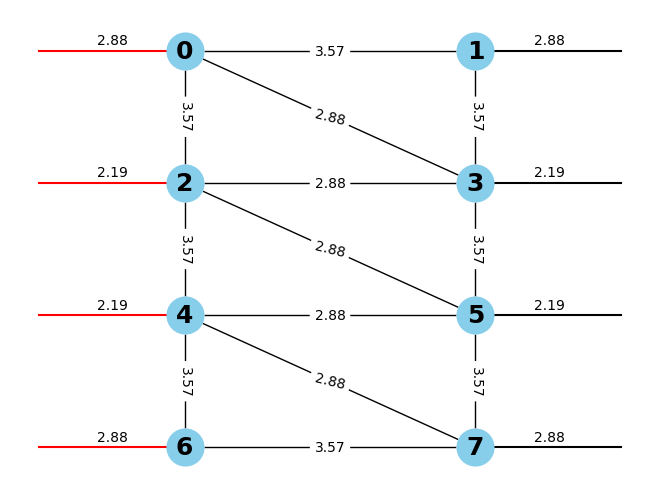

In [14]:
import numpy as np
import stim
import pymatching

d=3
T=3

circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

draw_matching_graph(matching, d, T)

In [9]:
from result_saver import SaverProvider
from soft_info import get_counts, get_KDEs
provider = SaverProvider()

# Code params
d = 3
T = 3
layout = [25, 19, 26, 22, 16] # Hardcoded for testing purposes, can be retrieved


job = provider.retrieve_job("cmyhbrqrmwhg008bs4h0")
memory = job.result().get_memory()

kde_dict, scaler_dict = get_KDEs(provider, 'ibmq_mumbai', layout, bandwidths=0.2, plot=False)

In [11]:
counts = get_counts(memory, kde_dict, scaler_dict, layout, T, verbose=True)


Processing 1000 shots: 100%|██████████| 1000/1000 [00:56<00:00, 17.79it/s]



Edge: (0, None)
Boundary edge weight:  4.98

Edge: (0, 1)
Data edge weight:  4.98

Edge: (0, 2)
Time edge weight:  0
LLH weight:  2.737216601099693

Edge: (0, 3)
Mixed edge weight:  4.978693041247711
LLH weight:  2.737216601099693

Edge: (1, 3)
Time edge weight:  0
LLH weight:  2.0087439187812866

Edge: (1, None)
Boundary edge weight:  4.98

Edge: (2, None)
Boundary edge weight:  4.98

Edge: (2, 3)
Data edge weight:  4.98

Edge: (2, 4)
Time edge weight:  0
LLH weight:  3.728923451895879

Edge: (2, 5)
Mixed edge weight:  4.978693041247711
LLH weight:  3.728923451895879

Edge: (3, 5)
Time edge weight:  0
LLH weight:  2.0015712298385058

Edge: (3, None)
Boundary edge weight:  4.98

Edge: (4, None)
Boundary edge weight:  4.98

Edge: (4, 5)
Data edge weight:  4.98

Edge: (4, 6)
Time edge weight:  0
LLH weight:  0.8807773165149033

Edge: (4, 7)
Mixed edge weight:  4.978693041247711
LLH weight:  0.8807773165149033

Edge: (5, 7)
Time edge weight:  0
LLH weight:  1.8744477275177776

Edge: (5, 

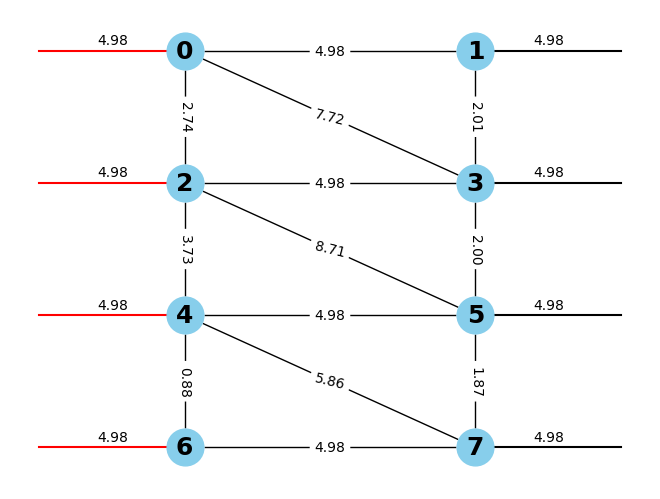

In [47]:
shot = 0
IQ_data = memory[shot]

soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.01, verbose=True)
draw_matching_graph(matching, d, T)

# Reweight to 1

In [49]:
def reweight_edges_to_one(matching: pymatching.Matching):
    for edge in matching.edges():
        src_node, tgt_node, edge_data = edge
        fault_ids = edge_data.get('fault_ids', set())
        error_probability = edge_data.get('error_probability', -1.0)
        
        if tgt_node is None:
            matching.add_boundary_edge(src_node, weight=1, fault_ids=fault_ids, 
                              error_probability=error_probability, merge_strategy="replace")
        else:
            matching.add_edge(src_node, tgt_node, weight=1, fault_ids=fault_ids, 
                          error_probability=error_probability, merge_strategy="replace")


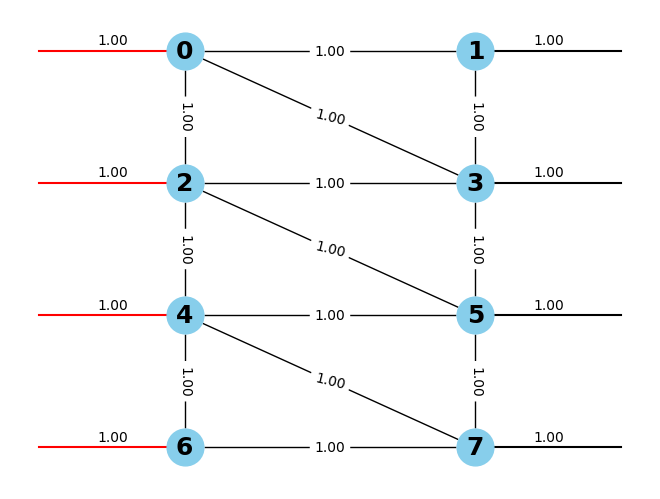

In [51]:
reweight_edges_to_one(matching)
draw_matching_graph(matching, d, T) 